# 1. Load Library

In this section we import all the necessary libraries.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import random
import pickle

from scipy.sparse import csr_matrix, vstack
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# from xgboost import XGBRegressor                  # XGBoost for GPU processing
from sklearn.preprocessing import OneHotEncoder     # Support Sparse Matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay   # Classification metrics

print('Libraries loaded successfully')

/opt/anaconda3/envs/CMU701/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries loaded successfully


# 2. Load Dataset

Load the dataset (e.g., a CSV file) and preview it.

In [5]:
# Download from Kaggle or load preprocessed data
current_path = None
if not current_path:
    path = kagglehub.dataset_download("samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc")
else:
    path = current_path
print("Path to dataset files:", path)

Path to dataset files: /Users/shijie/.cache/kagglehub/datasets/samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc/versions/2


In [4]:
from dataloader import load_gdsc, prepare_features, split_data
excluded_columns = ['LN_IC50', 'AUC', 'Z_SCORE', 'DRUG_ID', 'COSMIC_ID', 'DRUG_NAME', 'CELL_LINE_NAME']
df = load_gdsc(excluded_columns=excluded_columns)   # With Drop NaN & Exclude Outlier with IQR

# Create dummy variables for categorical features and split the data into training and testing sets with default test size of 0.2
X_dummy, y = prepare_features(df, encode_dummies=True)
X_label, _ = prepare_features(df, encode_dummies=False)
Xd_tr, Xd_te, Xl_tr, Xl_te, y_tr, y_te = split_data(X_dummy, X_label, y) 

In [4]:
df

,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
5,687448,COLO-829,SKCM,1003,Camptothecin,-1.235034,0.867348,0.557727,skin,melanoma,SKCM,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
7,687455,RT4,BLCA,1003,Camptothecin,-2.963191,0.821438,-0.383200,urogenital_system,Bladder,BLCA,MSS/MSI-L,D/F12,Adherent,Y,Y,Y,TOP1,DNA replication
8,687457,SW780,BLCA,1003,Camptothecin,-1.449138,0.905050,0.441154,urogenital_system,Bladder,BLCA,MSS/MSI-L,D/F12,Adherent,Y,Y,Y,TOP1,DNA replication
9,687459,TCCSUP,BLCA,1003,Camptothecin,-2.350633,0.843430,-0.049682,urogenital_system,Bladder,BLCA,MSS/MSI-L,D/F12,Adherent,Y,Y,Y,TOP1,DNA replication
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242029,1659818,MM1S,MM,2499,N-acetyl cysteine,9.316959,0.988236,-0.775041,myeloma,myeloma,MM,MSS/MSI-L,R,Suspension,Y,Y,Y,Metabolism,Metabolism
242030,1659928,SNU-175,COREAD,2499,N-acetyl cysteine,9.686618,0.976746,0.156872,large_intestine,large_intestine,COAD/READ,MSI-H,R,Suspension,Y,Y,Y,Metabolism,Metabolism
242031,1660034,SNU-407,COREAD,2499,N-acetyl cysteine,8.576377,0.913378,-1.626959,large_intestine,large_intestine,COAD/READ,MSI-H,R,Adherent,Y,Y,Y,Metabolism,Metabolism
242032,1660035,SNU-61,COREAD,2499,N-acetyl cysteine,9.686618,0.975001,0.608442,large_intestine,large_intestine,COAD/READ,MSS/MSI-L,R,Adherent,Y,Y,Y,Metabolism,Metabolism


In [2]:
X_label.shape

(166644, 12)

In [44]:
X_dummy.shape

(166644, 336)

# 3. Define Base Learner

Define the base learner that will be used in the different learning methods. For example, a simple Logistic Regression classifier.

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Define the base learner as random forest
base_learner = XGBRegressor(
        n_estimators=100,
        learning_rate=0.15,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.2,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective='reg:squarederror',
        tree_method='hist',
        random_state=42,
        n_jobs=-1
    )

print('Base learner defined:')
print(base_learner)

Base learner defined:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.2, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.15, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)


In [21]:
# PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=70)
Xd_pca = pca.fit_transform(Xd_tr)
Xd_te_pca = pca.transform(Xd_te)


# 4. Offline Learning Method

Implement the offline (batch) learning method where the base learner is trained on the entire dataset.

MSE of the model: 2.36
r2 of the model: 0.67


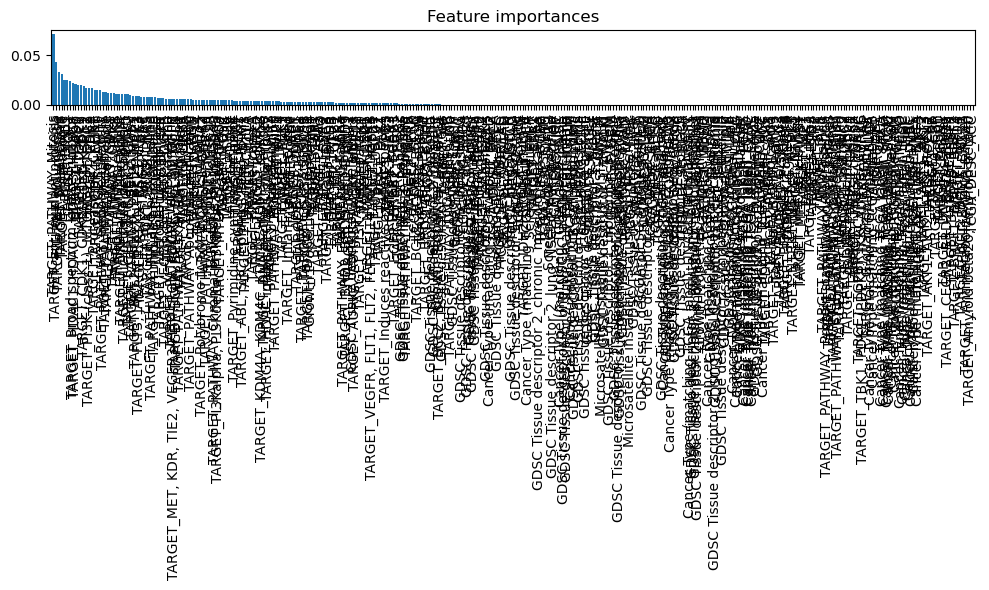

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

# Train the base learner
base_learner.fit(Xd_tr, y_tr)

# evaluate the model
y_pred = base_learner.predict(X=Xd_te)
mse = mean_squared_error(y_te, y_pred)
r2 = r2_score(y_te, y_pred)
print(f'MSE of the model: {mse:.2f}')
print(f'r2 of the model: {r2:.2f}')

# Visualize the feature importance
importances = base_learner.feature_importances_
indices = np.argsort(importances)[::-1]
features = Xd_tr.columns[indices]
# features = X_encoded.columns[indices]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), features, rotation=90)
plt.xlim([-1, len(features)])
plt.tight_layout()
plt.show()

MSE of the model: 2.07
r2 of the model: 0.71


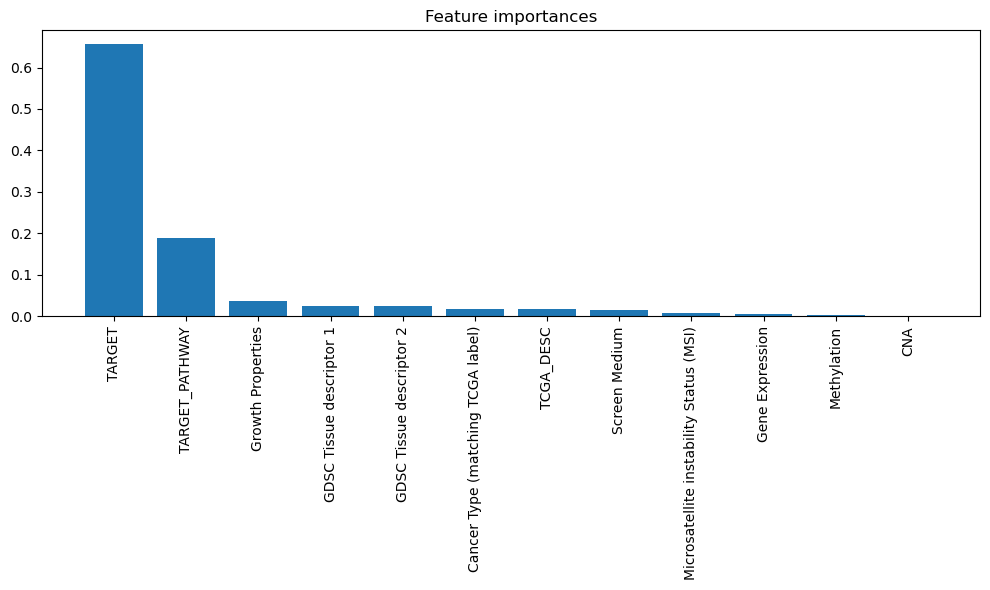

In [5]:
from sklearn.metrics import mean_squared_error, r2_score

# Train the base learner
base_learner.fit(Xl_tr, y_tr)

# evaluate the model
y_pred = base_learner.predict(Xl_te)
mse = mean_squared_error(y_te, y_pred)
r2 = r2_score(y_te, y_pred)
print(f'MSE of the model: {mse:.2f}')
print(f'r2 of the model: {r2:.2f}')

# Visualize the feature importance
importances = base_learner.feature_importances_
indices = np.argsort(importances)[::-1]
features = Xl_tr.columns[indices]
# features = X_encoded.columns[indices]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), features, rotation=90)
plt.xlim([-1, len(features)])
plt.tight_layout()
plt.show()

# 5. Passive Learning Method

Implement the passive learning method. This method randomly select instances from sample space for model training.

In [11]:
def random_sampling(X, y, n_samples, random_state):
    np.random.seed(random_state)
    indices = np.random.permutation(X.shape[0])
    sample_idx = indices[:n_samples]
    remaining_idx = indices[n_samples:]

    X_sampled = X.iloc[sample_idx]
    X_remaining = X.iloc[remaining_idx]

    y_sampled = y.iloc[sample_idx]
    y_remaining = y.iloc[remaining_idx]

    return X_sampled, X_remaining, y_sampled, y_remaining

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from xgboost import XGBRegressor

warnings.filterwarnings(
    "ignore",
    message="X has feature names, but .* was fitted without feature names",
    category=UserWarning,
    module="sklearn.utils.validation"
)

mse_passive = []
r2_passive = []

initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
n_runs = 5                  # Number of experiments

# Convert categorical features to numerical using one-hot encoding
# X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

for seed in range(n_runs):
    base_learner = XGBRegressor(
        n_estimators=100,
        learning_rate=0.15,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.2,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective='reg:squarederror',
        tree_method='hist',
        random_state=42,
        n_jobs=-1
    )

    # Split the data into training, validation, and testing sets
    X_test, y_test = Xl_te.copy(), y_te.copy()

    X_train, X_pool, y_train, y_pool = train_test_split(
        Xl_tr, y_tr,
        train_size=initial_train_size,
        random_state=seed
    )

    overall_mse = []
    overall_r2  = []

    n = 0
    # add the most uncertain sample to the training set
    while X_pool.shape[0] > 0:
        # Train the model
        model = base_learner.fit(X_train, y_train)

        # Evaluate the model on the test set
        y_pred = model.predict(X_test)
        # Calculate the mean squared error and R^2 score
        overall_mse.append(mean_squared_error(y_test, y_pred))
        overall_r2.append(r2_score(y_test, y_pred))
        
        # Randomly select a sample from the training set
        X_new, X_pool, y_new, y_pool = random_sampling(
            X_pool, y_pool, n_samples=100, random_state=seed)

        # Update the training set with the new sample
        # X_train = vstack([X_train, X_new])
        X_train = pd.concat([X_train, X_new], ignore_index=True)
        y_train = pd.concat([y_train, y_new], ignore_index=True)
        # Verbose output
        if n % 10 == 0:
            print(f"Training size: {X_train.shape[0]}, MSE: {overall_mse[-1]:.2f}, R2: {overall_r2[-1]:.2f}")
        n += 1

    mse_passive.append(overall_mse)
    r2_passive.append(overall_r2)
    print(f"Seed {seed} done")

Training size: 6765, MSE: 2.26, R2: 0.68
Training size: 7765, MSE: 2.23, R2: 0.68
Training size: 8765, MSE: 2.21, R2: 0.69
Training size: 9765, MSE: 2.22, R2: 0.68
Training size: 10765, MSE: 2.20, R2: 0.69
Training size: 11765, MSE: 2.19, R2: 0.69
Training size: 12765, MSE: 2.18, R2: 0.69
Training size: 13765, MSE: 2.18, R2: 0.69
Training size: 14765, MSE: 2.17, R2: 0.69
Training size: 15765, MSE: 2.15, R2: 0.70
Training size: 16765, MSE: 2.13, R2: 0.70
Training size: 17765, MSE: 2.13, R2: 0.70
Training size: 18765, MSE: 2.11, R2: 0.70
Training size: 19765, MSE: 2.12, R2: 0.70
Training size: 20765, MSE: 2.12, R2: 0.70
Training size: 21765, MSE: 2.13, R2: 0.70
Training size: 22765, MSE: 2.10, R2: 0.70
Training size: 23765, MSE: 2.10, R2: 0.70
Training size: 24765, MSE: 2.12, R2: 0.70
Training size: 25765, MSE: 2.10, R2: 0.70
Training size: 26765, MSE: 2.10, R2: 0.70
Training size: 27765, MSE: 2.09, R2: 0.70
Training size: 28765, MSE: 2.10, R2: 0.70
Training size: 29765, MSE: 2.08, R2: 0

Mean MSE of the model: 2.02
Mean r2 of the model: 0.71


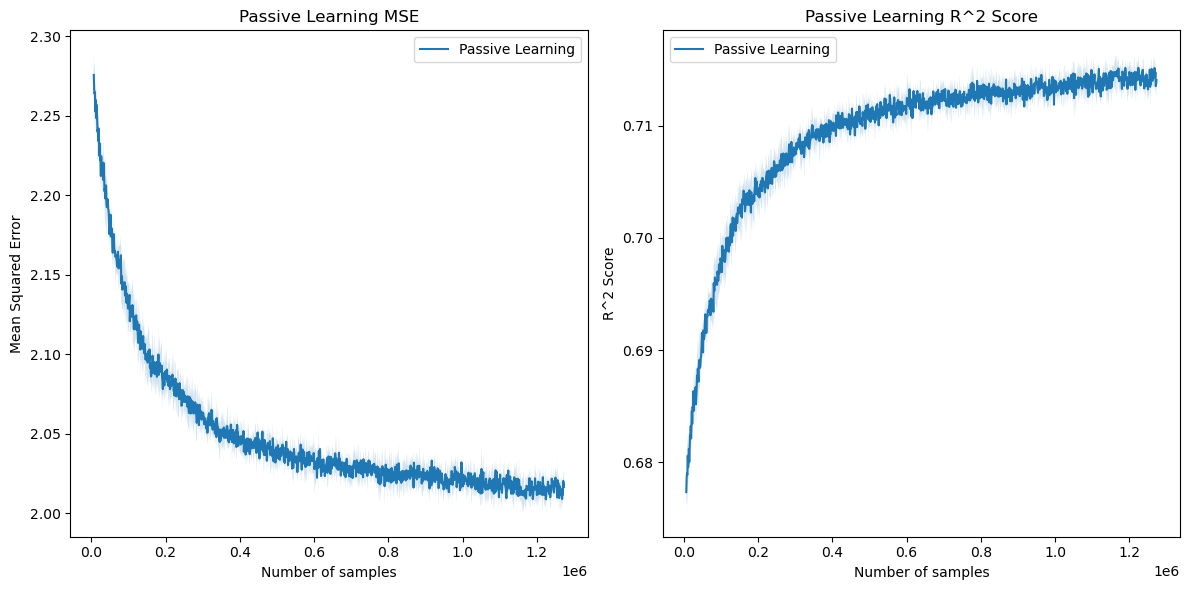

In [17]:
# Calculate the mean and standard deviation of MSE and R^2 scores
mse_passive = np.array(mse_passive)
mean_mse_passive = np.mean(mse_passive, axis=0)
std_mse_passive = np.std(mse_passive, axis=0)
r2_passive = np.array(r2_passive)
mean_r2_passive = np.mean(r2_passive, axis=0)
std_r2_passive = np.std(r2_passive, axis=0)
print(f'Mean MSE of the model: {mean_mse_passive[-1]:.2f}')
print(f'Mean r2 of the model: {mean_r2_passive[-1]:.2f}')
n_points = len(mean_mse_passive)
x_vals = 6765 + np.arange(n_points) * 1000

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x_vals, mean_mse_passive, label='Passive Learning')
plt.fill_between(x_vals, mean_mse_passive - std_mse_passive,
                 mean_mse_passive + std_mse_passive, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('Mean Squared Error')
plt.title('Passive Learning MSE')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x_vals, mean_r2_passive, label='Passive Learning')
plt.fill_between(x_vals, mean_r2_passive - std_r2_passive,
                 mean_r2_passive + std_r2_passive, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('R^2 Score')
plt.title('Passive Learning R^2 Score')
plt.legend()
plt.tight_layout()
plt.show()

# 6. Active Learning Method

### 6.1 Uncertainty based method


In [18]:
def uncertainty_sampling(model, X, y, n_samples, random_state=None):
    """
    Perform uncertainty sampling from the dataset based on least confidence.
    
    Parameters:
    -----------
    model : classifier object
        The trained classifier with predict_proba method
    X : {array-like, sparse matrix, dataframe} of shape (n_samples, n_features)
        The input samples
    y : array-like of shape (n_samples,)
        The target values
    n_samples : int
        Number of samples to select
    random_state : int or None, optional (default=None)
        Controls the randomness for tie-breaking
        
    Returns:
    --------
    X_sampled : selected samples
    X_remaining : remaining samples
    y_sampled : selected target values
    y_remaining : remaining target values
    """
    # get the number of trees
    booster = model.get_booster()
    n_trees = len(booster.get_dump())
    
    # predict the probabilities for each class
    preds = np.zeros((n_trees, X.shape[0]), dtype=float)
    for i in range(n_trees):
        preds[i] = model.predict(X, iteration_range=(i, i+1))
    
    # calculate the mean and variance of the predictions
    uncertainty = preds.var(axis=0)
    
    # sort the indices based on uncertainty and noise
    order = np.lexsort(-uncertainty)
    sampled_idx   = order[:n_samples]
    remaining_idx = order[n_samples:]
    
    # define the sampled and remaining datasets
    if hasattr(X, 'iloc'):
        X_sampled = X.iloc[sampled_idx]
        X_remaining = X.iloc[remaining_idx]
    else:
        X_sampled = X[sampled_idx]
        X_remaining = X[remaining_idx]
    
    if hasattr(y, 'iloc'):
        y_sampled = y.iloc[sampled_idx]
        y_remaining = y.iloc[remaining_idx]
    else:
        y_sampled = y[sampled_idx]
        y_remaining = y[remaining_idx]
    
    return X_sampled, X_remaining, y_sampled, y_remaining

In [31]:
def uncertainty_sampling_ensemble(models, X_pool, y_pool, n_samples):
    """
    用 ensemble 方差做不确定性度量，返回被采样和剩余的 X, y。
    """
    # shape = (n_models, n_pool_samples)
    all_preds = np.vstack([m.predict(X_pool) for m in models])
    # shape = (n_pool_samples,)
    variances = np.var(all_preds, axis=0)
    
    # sort the indices based on uncertainty and noise
    order = np.argsort(-variances)
    sampled_idx   = order[:n_samples]
    remaining_idx = order[n_samples:]
    
    # separate sampled and remaining datasets
    X_sampled   = X_pool.iloc[sampled_idx]   if hasattr(X_pool, 'iloc') else X_pool[sampled_idx]
    X_remaining = X_pool.iloc[remaining_idx] if hasattr(X_pool, 'iloc') else X_pool[remaining_idx]
    y_sampled   = y_pool.iloc[sampled_idx]   if hasattr(y_pool, 'iloc') else y_pool[sampled_idx]
    y_remaining = y_pool.iloc[remaining_idx] if hasattr(y_pool, 'iloc') else y_pool[remaining_idx]
    
    return X_sampled, X_remaining, y_sampled, y_remaining

In [32]:
def train_ensemble(X_train, y_train, n_models=5, **xgb_kwargs):
    models = []
    for seed in range(n_models):
        m = XGBRegressor(
            random_state=seed,
            **xgb_kwargs
        )
        m.fit(X_train, y_train)
        models.append(m)
    return models

In [38]:
test_size = 0.2             # Percentage of data for testing
initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
max_train_size = 1.00       # Percentage of data for maximum training size, excluding test set 
n_runs = 5                  # Number of experiments

mse_uncertainty = []
r2_uncertainty = []

for seed in range(n_runs):
    # Split the data into training, validation, and testing sets
    X_test, y_test = Xl_te.copy(), y_te.copy()

    X_train, X_pool, y_train, y_pool = train_test_split(
        Xl_tr, y_tr,
        train_size=initial_train_size,
        random_state=seed)
    overall_mse = []
    overall_r2 = []
    n=0
    while X_pool.shape[0] >0 :
        models = train_ensemble(
            X_train, y_train,
            n_models=5,
            n_estimators=100,
            max_depth=6,
            learning_rate=0.15,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.2,
            reg_alpha=0.1,
            reg_lambda=1.0,
            objective='reg:squarederror',
            tree_method='hist'
        )

        # Evaluate the model on the test set
        # y_pred = model.predict(X_test)
        # overall_mse.append(mean_squared_error(y_test, y_pred))
        # overall_r2.append(r2_score(y_test, y_pred))
        y_pred = np.mean([m.predict(X_test) for m in models], axis=0)
        overall_mse.append(mean_squared_error(y_test, y_pred))
        overall_r2 .append(r2_score(y_test, y_pred))

        # Randomly select a sample from the training set
        X_new, X_pool, y_new, y_pool = uncertainty_sampling_ensemble(
            models, X_pool, y_pool, n_samples=100)

        # Update the training set with the new sample
        X_train = pd.concat([X_train, X_new], ignore_index=True)
        y_train = pd.concat([y_train, y_new], ignore_index=True)

        # Verbose output
        if n % 10 == 0:
            print(f"Training size: {X_train.shape[0]}, MSE: {overall_mse[-1]:.2f}, R2: {overall_r2[-1]:.2f}")
        n += 1

    mse_uncertainty.append(overall_mse)
    r2_uncertainty.append(overall_r2)
    print(f"Seed {seed} done")

# Save results
# with open('./results/uncertainty_sampling_results_regression.pkl', 'wb') as f:
#     pickle.dump((mse_uncertainty, r2_uncertainty), f)

Training size: 6765, MSE: 2.24, R2: 0.68
Training size: 7765, MSE: 2.22, R2: 0.68
Training size: 8765, MSE: 2.19, R2: 0.69
Training size: 9765, MSE: 2.19, R2: 0.69
Training size: 10765, MSE: 2.19, R2: 0.69
Training size: 11765, MSE: 2.17, R2: 0.69
Training size: 12765, MSE: 2.16, R2: 0.69
Training size: 13765, MSE: 2.15, R2: 0.70
Training size: 14765, MSE: 2.15, R2: 0.70
Training size: 15765, MSE: 2.14, R2: 0.70
Training size: 16765, MSE: 2.13, R2: 0.70
Training size: 17765, MSE: 2.12, R2: 0.70
Training size: 18765, MSE: 2.10, R2: 0.70
Training size: 19765, MSE: 2.10, R2: 0.70
Training size: 20765, MSE: 2.10, R2: 0.70
Training size: 21765, MSE: 2.09, R2: 0.70
Training size: 22765, MSE: 2.09, R2: 0.70
Training size: 23765, MSE: 2.10, R2: 0.70
Training size: 24765, MSE: 2.08, R2: 0.70
Training size: 25765, MSE: 2.09, R2: 0.70
Training size: 26765, MSE: 2.09, R2: 0.70
Training size: 27765, MSE: 2.08, R2: 0.71
Training size: 28765, MSE: 2.08, R2: 0.70
Training size: 29765, MSE: 2.08, R2: 0

Mean MSE of the model: 2.0102
Mean R2 Score of the model: 0.7150


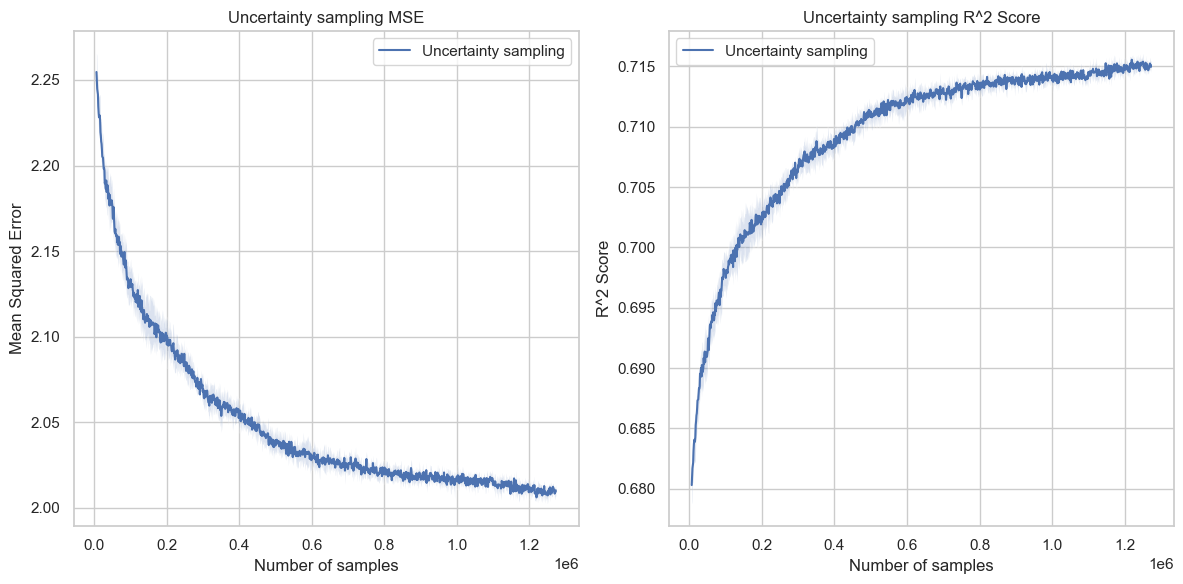

In [39]:
# Calculate the mean and standard deviation of accuracy and F1 scores
mse_uncertainty = np.array(mse_uncertainty)
mean_mse_uncertainty = np.mean(mse_uncertainty, axis=0)
std_mse_uncertainty = np.std(mse_uncertainty, axis=0)
r2_uncertainty = np.array(r2_uncertainty)
mean_r2_uncertainty = np.mean(r2_uncertainty, axis=0)
std_r2_uncertainty = np.std(r2_uncertainty, axis=0)
print(f'Mean MSE of the model: {mean_mse_uncertainty[-1]:.4f}')
print(f'Mean R2 Score of the model: {mean_r2_uncertainty[-1]:.4f}')
n_points = len(mean_mse_uncertainty)
x_vals = 6765 + np.arange(n_points) * 1000

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x_vals, mean_mse_uncertainty, label='Uncertainty sampling')
plt.fill_between(x_vals, mean_mse_uncertainty - std_mse_uncertainty,
                 mean_mse_uncertainty + std_mse_uncertainty, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('Mean Squared Error')
plt.title('Uncertainty sampling MSE')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x_vals, mean_r2_uncertainty, label='Uncertainty sampling')
plt.fill_between(x_vals, mean_r2_uncertainty - std_r2_uncertainty,
                 mean_r2_uncertainty + std_r2_uncertainty, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('R^2 Score')
plt.title('Uncertainty sampling R^2 Score')
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
def density_batch_selection(models, X_pool, batch_size=100):
    # calculate the density of the pool
    print('Calculating density of the pool...')
    S = cosine_similarity(X_pool)
    density = S.mean(axis=1)

    # calculate the uncertainty of the pool
    preds = np.stack([m.predict(X_pool) for m in models], axis=0)
    utility = preds.var(axis=0)  

    # score = utility * density
    score = utility * density

    # select the samples with the highest score
    selected_idx = np.argsort(-score)[:batch_size]
    return selected_idx

In [2]:
def train_ensemble(X_train, y_train, n_models=5, **xgb_kwargs):
    models = []
    for seed in range(n_models):
        m = XGBRegressor(
            random_state=seed,
            **xgb_kwargs
        )
        m.fit(X_train, y_train)
        models.append(m)
    return models

In [7]:
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from xgboost import XGBRegressor

test_size = 0.2             # Percentage of data for testing
initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
max_train_size = 1.00       # Percentage of data for maximum training size, excluding test set 
n_runs = 5                  # Number of experiments

mse_doe = []
r2_doe = []

# print("calculating D-optimality indices")
# sequences = select_greedy_d_optimality(X_pool.values, X_pool.shape[0])
# print("D-optimality indices calculated")

for seed in range(n_runs):
    # Split the data into training, validation, and testing sets
    X_test, y_test = Xl_te.copy(), y_te.copy()

    X_train, X_pool, y_train, y_pool = train_test_split(
        Xl_tr, y_tr,
        train_size=initial_train_size,
        random_state=seed)
    overall_mse = []
    overall_r2 = []
    n=0

    while X_pool.shape[0] >0 :
        models = train_ensemble(
            X_train, y_train,
            n_models=5,
            n_estimators=100,
            max_depth=6,
            learning_rate=0.15,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.2,
            reg_alpha=0.1,
            reg_lambda=1.0,
            objective='reg:squarederror',
            tree_method='hist'
        )

        # Evaluate the model on the test set
        y_pred = np.mean([m.predict(X_test) for m in models], axis=0)
        overall_mse.append(mean_squared_error(y_test, y_pred))
        overall_r2 .append(r2_score(y_test, y_pred))

        selected = density_batch_selection(models,X_pool.values if hasattr(X_pool, 'values') else X_pool,100)

        # Select the first 100 samples for training
        X_new = X_pool.iloc[selected]
        y_new = y_pool.iloc[selected]
        X_pool = X_pool.drop(X_pool.index[selected]).reset_index(drop=True)
        y_pool = y_pool.drop(y_pool.index[selected]).reset_index(drop=True)

        # Update the training set with the new sample
        X_train = pd.concat([X_train, X_new], ignore_index=True)
        y_train = pd.concat([y_train, y_new], ignore_index=True)

        # Verbose output
        if n % 100 == 0:
            print(f"Training size: {X_train.shape[0]}, MSE: {overall_mse[-1]:.2f}, R2: {overall_r2[-1]:.2f}")
        n += 1

    mse_doe.append(overall_mse)
    r2_doe.append(overall_r2)
    print(f"Seed {seed} done")

Calculating density of the pool...


: 

## Expected model change

In [12]:
from sklearn.base import clone
def estimate_utilities_eer(model, X_train, y_train, X_test, y_test,
                           X_pool, candidate_idx, n_extra_rounds=10, **xgb_kwargs):
    """
    For each index in candidate_idx, simulate adding that point (with its predicted label)
    to the training set, retrain for n_extra_rounds, and measure MSE reduction on (X_test,y_test).
    Returns a list of (idx, utility) tuples.
    """
    base_mse = mean_squared_error(y_test, model.predict(X_test))
    utilities = []
    # We'll retrain clones of the model for a small extra number of rounds
    for i in candidate_idx:
        x_i = X_pool.iloc[[i]]
        # 1) predict its pseudo-label
        y_hat = model.predict(x_i)[0]
        # 2) build augmented train set
        X_aug = pd.concat([X_train, x_i], ignore_index=True)
        y_aug = pd.concat([y_train, pd.Series([y_hat])], ignore_index=True)
        # 3) clone and continue training
        m = clone(model)
        # continue training for n_extra_rounds:
        # note: sklearn API allows xgb_model to warm-start
        m.set_params(n_estimators=n_extra_rounds, **xgb_kwargs)
        # pass the original booster as xgb_model to warm-start
        m.fit(X_aug, y_aug,
              xgb_model=model.get_booster(),
              verbose=False)
        # 4) measure new MSE
        new_mse = mean_squared_error(y_test, m.predict(X_test))
        utilities.append((i, base_mse - new_mse))
    return utilities

In [9]:
def eer_batch_selection(model, X_train, y_train, X_test, y_test,
                        X_pool, batch_size=100, pool_subset=500,
                        n_extra_rounds=10, **xgb_kwargs):
    """
    1) Sample up to pool_subset candidates from X_pool
    2) Estimate their Expected Error Reduction utilities
    3) Return the top batch_size indices (relative to X_pool)
    """
    # randomly subsample candidate indices for speed
    all_idx = np.arange(len(X_pool))
    if len(all_idx) > pool_subset:
        cand_idx = np.random.choice(all_idx, size=pool_subset, replace=False)
    else:
        cand_idx = all_idx

    utils = estimate_utilities_eer(
        model, X_train, y_train, X_test, y_test,
        X_pool, cand_idx,
        n_extra_rounds=n_extra_rounds,
        **xgb_kwargs
    )
    # pick top utilities
    utils.sort(key=lambda x: x[1], reverse=True)
    selected = [idx for idx, u in utils[:batch_size]]
    return selected

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from xgboost import XGBRegressor

test_size = 0.2             # Percentage of data for testing
initial_train_size = 0.05   # Percentage of data for initial training, excluding test set
max_train_size = 1.00       # Percentage of data for maximum training size, excluding test set 
n_runs = 3                  # Number of experiments

mse_doe = []
r2_doe = []

# print("calculating D-optimality indices")
# sequences = select_greedy_d_optimality(X_pool.values, X_pool.shape[0])
# print("D-optimality indices calculated")

for seed in range(n_runs):
    # Split the data into training, validation, and testing sets
    X_test, y_test = Xl_te.copy(), y_te.copy()

    X_train, X_pool, y_train, y_pool = train_test_split(
        Xl_tr, y_tr,
        train_size=initial_train_size,
        random_state=seed)
    overall_mse = []
    overall_r2 = []
    n=0
    base_learner = XGBRegressor(
        n_estimators=100,
        learning_rate=0.15,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.2,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective='reg:squarederror',
        tree_method='hist',
        random_state=42,
        n_jobs=-1
    )

    pool_subset = 1000
    extra_rounds = 5

    while len(X_pool) > 0:
        model = base_learner.fit(X_train, y_train)
        # Evaluate the model on the test set
        y_pred = model.predict(X_test)
        overall_mse.append(mean_squared_error(y_test, y_pred))
        overall_r2 .append(r2_score(y_test, y_pred))

        selected = eer_batch_selection(
            base_learner,
            X_train, y_train,
            X_test, y_test,
            X_pool,
            batch_size=100,
            pool_subset=pool_subset,
            n_extra_rounds=extra_rounds,
            max_depth=6,
            learning_rate=0.15,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.2,
            reg_alpha=0.1,
            reg_lambda=1.0,
            objective='reg:squarederror',
            tree_method='hist',
            random_state=seed
        )

        # Select the first 100 samples for training
        X_new = X_pool.iloc[selected]
        y_new = y_pool.iloc[selected]
        X_pool = X_pool.drop(X_pool.index[selected]).reset_index(drop=True)
        y_pool = y_pool.drop(y_pool.index[selected]).reset_index(drop=True)

        # Update the training set with the new sample
        X_train = pd.concat([X_train, X_new], ignore_index=True)
        y_train = pd.concat([y_train, y_new], ignore_index=True)

        # Verbose output
        if n % 100 == 0:
            print(f"Training size: {X_train.shape[0]}, MSE: {overall_mse[-1]:.2f}, R2: {overall_r2[-1]:.2f}")
        n += 1

    mse_doe.append(overall_mse)
    r2_doe.append(overall_r2)
    print(f"Seed {seed} done")

Training size: 6765, MSE: 2.26, R2: 0.68


## Plot

In [22]:
def plot_learning_curves(result_dict, 
                        save_path=None, 
                        dpi=300):
    """
    Plot learning curves for accuracy and F1 score across multiple experiments with std deviation bands.
    
    Args:
        result_dict: Dictionary containing experimental results in format:
            {
                "experiment1": {
                    "MSE": [n_runs arrays of length n_samples],
                    "r2": [n_runs arrays of length n_samples]
                },
                ...
            }
        save_path: Path to save the figure (if None, figure won't be saved)
        dpi: Resolution of the output figure
    """
    plt.figure(figsize=(12, 6))
    
    # Left plot - Accuracy
    plt.subplot(1, 2, 1)
    for exp_name, results in result_dict.items():
        # Calculate mean and std across runs
        acc_data = np.array(results["accuracy"])
        mean_acc = np.mean(acc_data, axis=0)
        std_acc = np.std(acc_data, axis=0)
        
        # Plot without specifying color
        line = plt.plot(mean_acc, label=exp_name)[0]
        
        # Use the automatically assigned color for the fill
        plt.fill_between(np.arange(len(mean_acc)),
                        mean_acc - std_acc,
                        mean_acc + std_acc,
                        color=line.get_color(),  # Use the same color as line
                        alpha=0.2)
    
    plt.xlabel('Number of Samples')
    plt.ylabel('MSE')
    plt.title('MSE Learning Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Right plot - F1 Score
    plt.subplot(1, 2, 2)
    for exp_name, results in result_dict.items():
        f1_data = np.array(results["f1"])
        mean_f1 = np.mean(f1_data, axis=0)
        std_f1 = np.std(f1_data, axis=0)
        
        # Get the same color as used in accuracy plot
        line = plt.plot(mean_f1, label=exp_name)[0]
        
        plt.fill_between(np.arange(len(mean_f1)),
                        mean_f1 - std_f1,
                        mean_f1 + std_f1,
                        color=line.get_color(),
                        alpha=0.2)
    
    plt.xlabel('Number of Samples')
    plt.ylabel('R2 Score')
    plt.title('R2 Score Learning Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    plt.show()

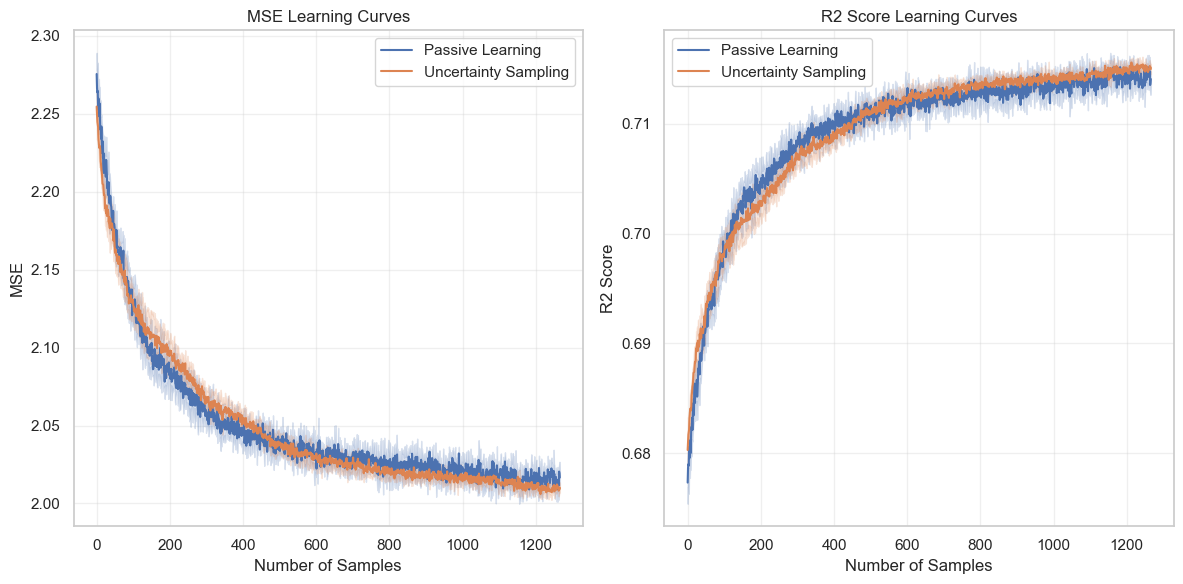

In [40]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

result_dict = {
    "Passive Learning": {
        "accuracy": mse_passive,
        "f1": r2_passive
    },
    "Uncertainty Sampling": {
        "accuracy": mse_uncertainty,
        "f1": r2_uncertainty
    }
}

plot_learning_curves(result_dict, save_path=None)

/opt/anaconda3/envs/CMU701/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


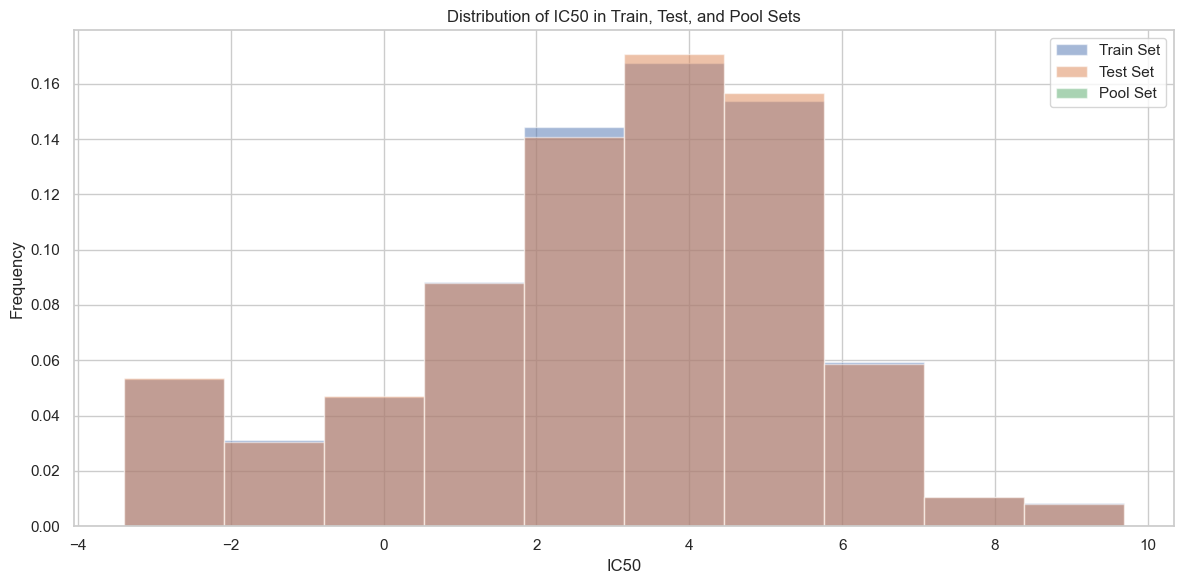

In [26]:
# plot the distribution of the IC50 in X_encoded
plt.figure(figsize=(12, 6))
# plt.subplot(1, 1, 1)
plt.hist(y_train, alpha=0.5, label='Train Set', density=True)
plt.hist(y_test, alpha=0.5, label='Test Set', density=True)
plt.hist(y_pool, alpha=0.5, label='Pool Set', density=True)
plt.xlabel('IC50')
plt.ylabel('Frequency')
plt.title('Distribution of IC50 in Train, Test, and Pool Sets')
plt.legend()
plt.tight_layout()
# plt.savefig('./figures/Distribution_of_IC50.png', dpi=300)
plt.show()

In [ ]:
def hoi_batch_selection(clf, X_unlabeled, batch_size=3, alpha=0.5, gamma=1.0):
    n_unlabeled = len(X_unlabeled)
    if n_unlabeled <= batch_size:
        return np.arange(n_unlabeled)

    # 1) Compute margin-based uncertainty: smaller margin => higher uncertainty
    margins = np.abs(clf.decision_function(X_unlabeled))
    epsilon = 1e-8
    # Define uncertainty as 1 / (margin + epsilon)
    uncertainties = 1.0 / (margins + epsilon)

    # 2) Greedy selection
    chosen_indices = []
    chosen_mask = np.zeros(n_unlabeled, dtype=bool)

    # We'll store sum of similarities for each candidate x to the chosen set S
    sum_sim = np.zeros(n_unlabeled)

    def rbf_sim(a, b, gamma):
        """RBF-based similarity function."""
        diff = a - b
        return np.exp(-gamma * np.dot(diff, diff))

    for i in range(batch_size):
        # Compute scores for each candidate x (not yet chosen):
        scores = uncertainties - alpha * sum_sim

        # Exclude already chosen points by setting their scores to -inf
        scores[chosen_mask] = -np.inf

        # Pick the best point
        best_idx = np.argmax(scores)
        chosen_indices.append(best_idx)
        chosen_mask[best_idx] = True

        # Update sum_sim for all remaining points
        for i in range(n_unlabeled):
            if not chosen_mask[i]:
                sim_val = rbf_sim(X_unlabeled[i], X_unlabeled[best_idx], gamma=gamma)
                sum_sim[i] += sim_val

    return np.array(chosen_indices)
